<a href="https://colab.research.google.com/github/Joycechidi/Secure-and-Private-AI/blob/master/inference_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise: Implement the validation loop below and print out the total accuracy after the loop.
Try to get accuracy of above 80%

In [0]:
!wget https://github.com/udacity/deep-learning-v2-pytorch/raw/master/intro-to-pytorch/helper.py

--2019-06-15 12:02:28--  https://github.com/udacity/deep-learning-v2-pytorch/raw/master/intro-to-pytorch/helper.py
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py [following]
--2019-06-15 12:02:33--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2019-06-15 12:02:34 (59.7 MB/s) - ‘helper.py’ saved [2813

In [0]:
import torch

from torch import optim
from torchvision import datasets, transforms
import helper

from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,), (0.5,)),
                               ])

# #Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


#Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


0it [00:00, ?it/s]

26427392it [00:02, 10760827.25it/s]                             


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 73496.33it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 3031479.09it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 26528.81it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
#Create a normal model as before

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1= nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    
    
  def forward(self, x):
    #make sure input tensor is flattened
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)
    
    return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. The developer has to define the performance. Typicaly, this is just accuracy. The percentage of classes the network predicted correctly.


First, a forward pass with one batch from the set.

In [0]:
model = Classifier()


images, labels = next(iter(testloader))
#Get the class probabiities
ps = torch.exp(model(images))

#Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the $k$ highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [0]:
top_p, top_class = ps.topk(1, dim=1)
#look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9],
        [9]])


Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes. Here top_class is a 2D tensor with shape (64, 1) while labels is 1D with shape (64). To get the equality to work out the way we want, top_class and labels must have the same shape.

If we do

equals = top_class == labels
equals will have shape (64, 64), try it yourself. What it's doing is comparing the one element in each row of top_class with each element in labels which returns 64 True/False boolean values for each row.

In [0]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. equals has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to torch.mean. If only it was that simple. If you try torch.mean(equals), you'll get an error

RuntimeError: mean is not implemented for type torch.ByteTensor
This happens because equals has type torch.ByteTensor but torch.mean isn't implement for tensors with that type. So we'll need to convert equals to a float tensor. Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item().

In [0]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 14.0625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up the training by turning off gradients using torch.no_grad():

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
                # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.488..  Test Accuracy: 0.818
Epoch: 2/30..  Training Loss: 0.386..  Test Loss: 0.396..  Test Accuracy: 0.854
Epoch: 3/30..  Training Loss: 0.354..  Test Loss: 0.382..  Test Accuracy: 0.865
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.392..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.368..  Test Accuracy: 0.875
Epoch: 6/30..  Training Loss: 0.303..  Test Loss: 0.358..  Test Accuracy: 0.873
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.351..  Test Accuracy: 0.877
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.380..  Test Accuracy: 0.871
Epoch: 9/30..  Training Loss: 0.276..  Test Loss: 0.373..  Test Accuracy: 0.868
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.359..  Test Accuracy: 0.873
Epoch: 11/30..  Training Loss: 0.263..  Test Loss: 0.365..  Test Accuracy: 0.877
Epoch: 12/30..  Training Loss: 0.256..  Test Loss: 0.350..  Test Accuracy: 0.883
Epoch: 13/30..  Training Loss: 0.248.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

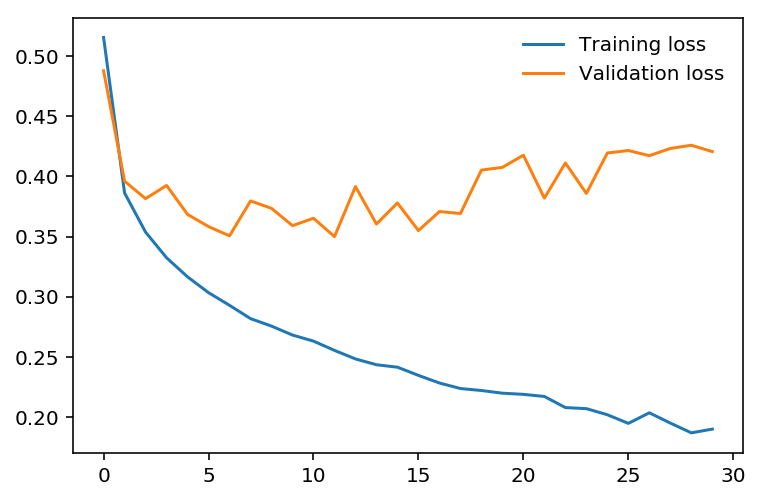

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Overfitting
If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called early-stopping. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the nn.Dropout module.

**Add Dropout to my model and trsin iton Fashion-MNIST again, See if you can get a lower validation loss.**

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.611..  Test Loss: 0.466..  Test Accuracy: 0.838
Epoch: 2/30..  Training Loss: 0.487..  Test Loss: 0.432..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.455..  Test Loss: 0.426..  Test Accuracy: 0.848
Epoch: 4/30..  Training Loss: 0.433..  Test Loss: 0.412..  Test Accuracy: 0.852
Epoch: 5/30..  Training Loss: 0.424..  Test Loss: 0.417..  Test Accuracy: 0.848
Epoch: 6/30..  Training Loss: 0.417..  Test Loss: 0.409..  Test Accuracy: 0.848
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.392..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.403..  Test Loss: 0.396..  Test Accuracy: 0.863
Epoch: 9/30..  Training Loss: 0.397..  Test Loss: 0.388..  Test Accuracy: 0.865
Epoch: 10/30..  Training Loss: 0.392..  Test Loss: 0.405..  Test Accuracy: 0.856
Epoch: 11/30..  Training Loss: 0.388..  Test Loss: 0.378..  Test Accuracy: 0.870
Epoch: 12/30..  Training Loss: 0.385..  Test Loss: 0.380..  Test Accuracy: 0.870
Epoch: 13/30..  Training Loss: 0.387.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

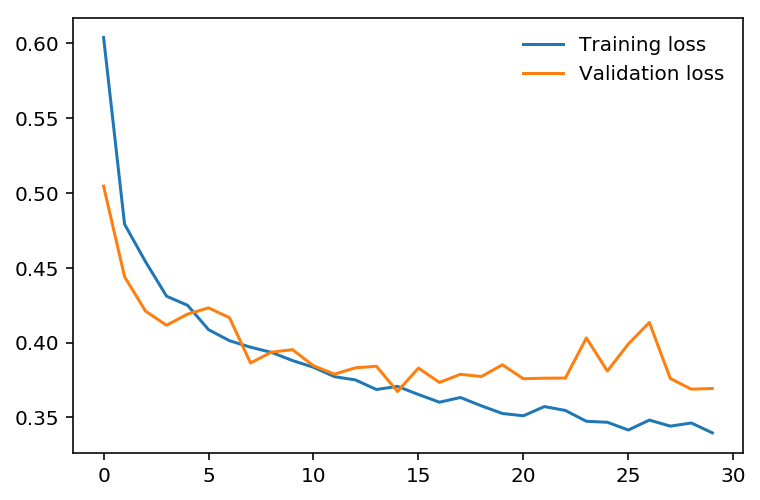

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Inference
Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with model.eval(). You'll also want to turn off autograd with the torch.no_grad() context.

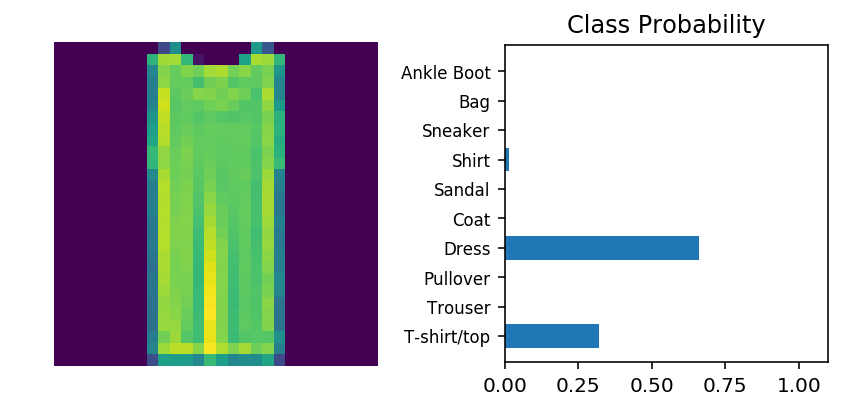

In [0]:
import helper

#Test out the network
                                               
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

#Convert 2D image to ID vector
img = img.view(1, 784)


#Calculate the class probabilities (softmax) for img

with torch.no_grad():
  output = model.forward(img)
  
  
ps = torch.exp(output)

#Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [0]:
pwd

'/content'